## Prepare and read data

In [1]:
import gc
import itertools
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD

In [2]:
pd.set_option("max_columns", 300)
pd.set_option("max_rows", 500)

In [3]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

In [4]:
def feature_cache(reset=False):
    def _feature_cache(func):
        def wrapper(train_df, test_df, *args):
            func_name = func.__name__
            train_feat_path = Path("../feature") / f"train_{func_name}.pkl"
            test_feat_path = Path("../feature") / f"test_{func_name}.pkl"
            # if feature exists, load feature
            if train_feat_path.exists() and test_feat_path.exists() and not reset:
                train_feats = pd.read_pickle(train_feat_path).reset_index(drop=True)
                test_feats = pd.read_pickle(test_feat_path).reset_index(drop=True)
                train_df = pd.concat([train_df, train_feats], axis=1)
                test_df = pd.concat([test_df, test_feats], axis=1)
            # if not exists, make feature and save as pickle
            else:
                before_cols = train_df.columns.tolist()
                train_df, test_df = func(train_df, test_df, *args)
                after_cols = train_df.columns.tolist()
                new_cols = [c for c in after_cols if c not in before_cols]
                train_feats = train_df[new_cols]
                test_feats = test_df[new_cols]
                train_feats.to_pickle(train_feat_path)
                test_feats.to_pickle(test_feat_path)            
            return train_df, test_df
        return wrapper

    return _feature_cache

## Feature Engineering

In [5]:
def get_multi_cat_cols(train_df):
    tmp = train_df.iloc[:1000]
    multi_cols = []
    for c in train_df.columns:
        sep_num = tmp[c].astype(str).fillna("").str.contains(";").sum()
        if sep_num > 10:
            multi_cols.append(c)
    return multi_cols

In [6]:
original_cols = train_df.columns.tolist()

In [7]:
multi_cat_cols = get_multi_cat_cols(train_df)

In [8]:
nume_cols = [
    c for c in list(np.setdiff1d(original_cols, multi_cat_cols))
    if c not in ["Salary", "No"] and "float" in train_df[c].dtype.name
]

In [9]:
cat_cols = [c for c in train_df.columns if c not in multi_cat_cols + nume_cols + ["Salary", "No"]]

In [10]:
non_basic_nume_cols = []
non_basic_cat_cols = []

In [11]:
len(original_cols), len(cat_cols), len(nume_cols), len(multi_cat_cols)

(128, 65, 40, 21)

### rank feature

In [12]:
def add_rank_feature(df):
    rank_prefix_list = [
        "AssessBenefits",
        "AssessJob",
        "JobContactPriorities",
        "JobEmailPriorities",
        "AdsPriorities",
    ]
    for prefix in tqdm(rank_prefix_list):
        rank_cols = [c for c in df.columns if prefix in c]
        col_pairs = itertools.combinations(rank_cols, 2)
        for col_a, col_b in col_pairs:
            df[f"rank_diff_{prefix}_{col_a}_{col_b}"] = (df[col_a] - df[col_b]) / np.log2(df[[col_a, col_b]].max(axis=1))
    return df

In [13]:
train_df = add_rank_feature(train_df)
test_df = add_rank_feature(test_df)

### Multi-category encoding

In [14]:
for c in tqdm(multi_cat_cols):
    binarizer = MultiLabelBinarizer()
    train_multi_srs = train_df[c].map(lambda x: x.split(";") if x is not np.nan else [])
    test_multi_srs = test_df[c].map(lambda x: x.split(";") if x is not np.nan else [])
    train_arr = binarizer.fit_transform(train_multi_srs)
    test_arr = binarizer.transform(test_multi_srs)
    feat_cols = [f"ohe_{c}_{val}" for val in binarizer.classes_]
    train_feat_df = pd.DataFrame(train_arr, columns=feat_cols, dtype=np.int8)
    test_feat_df = pd.DataFrame(test_arr, columns=feat_cols, dtype=np.int8)
    all_feat_df = pd.concat([train_feat_df, test_feat_df], axis=0, ignore_index=True)
    train_feat_df[f"sum_answer_{c}"] = (train_df[c].str.count(";") + 1).fillna(-1).astype(np.int8)
    test_feat_df[f"sum_answer_{c}"] = (test_df[c].str.count(";") + 1).fillna(-1).astype(np.int8)
    train_df = pd.concat([train_df, train_feat_df], axis=1)
    test_df = pd.concat([test_df, test_feat_df], axis=1)
    # ohe_featureはcategoryとnumerical両方として扱う
    nume_cols += feat_cols
    cat_cols += feat_cols
    # non_basic_nume_cols.append(f"sum_answer_{c}")
    # SVD
    svd = TruncatedSVD(n_components=2, random_state=2020)
    all_svd_feats = pd.DataFrame(svd.fit_transform(all_feat_df), columns=[f"svd_{c}_{ix}" for ix in range(2)])
    train_df = pd.concat([train_df, all_svd_feats.iloc[:len(train_df)]], axis=1)
    test_df = pd.concat([test_df, all_svd_feats.iloc[len(train_df):].reset_index(drop=True)], axis=1)

### Simple-category encoding

In [15]:
for c in cat_cols:
    train_df[c], uniques = pd.factorize(train_df[c], sort=True)
    test_df[c] = uniques.get_indexer(test_df[c])

### Reduce data memory

In [16]:
for c in nume_cols:
    if train_df[c].nunique() > 1000:
        train_df[c] = train_df[c].astype(np.float32)
        test_df[c] = test_df[c].astype(np.float32)
    else:
        train_df[c] = train_df[c].astype(np.float16)
        test_df[c] = test_df[c].astype(np.float16)

In [17]:
for c in cat_cols:
    if train_df[c].max() > 32767:
        train_df[c] = train_df[c].astype(np.int32)
        test_df[c] = test_df[c].astype(np.int32)
    else:
        train_df[c] = train_df[c].astype(np.int16)
        test_df[c] = test_df[c].astype(np.int16)            

In [18]:
train_df.shape, test_df.shape

((33857, 659), (11259, 658))

### Change Category Name

In [19]:
train_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train_df.columns]
test_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_df.columns]

### Aggregation

In [20]:
def get_basic_importance_cols(use_num=50):
    # basicなモデルのimportanceを読み込み
    importance_df = pd.read_csv("../data/importance/003_importance.csv")
    imp_feats = importance_df["feature"].iloc[:use_num].tolist()
    return imp_feats

In [21]:
def make_agg_feature(train_df, test_df):
    imp_feats = get_basic_importance_cols(use_num=50)
    imp_cat_cols = [c for c in cat_cols if c in imp_feats] + non_basic_cat_cols
    imp_nume_cols = [c for c in nume_cols if c in imp_feats] + non_basic_nume_cols
    print(f"use cat col: {len(imp_cat_cols)}  nume col: {len(imp_nume_cols)}")
    #imp_nume_cols += [c for c in train_df.columns if c[:8] == "sum_answ"]
    all_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    for cat_col in tqdm(imp_cat_cols):
        for nume_col in imp_nume_cols:
            # one-hotは同じカテゴリの場合がある
            if cat_col == nume_col:
                continue
            all_df[f"agg_mean_{cat_col}_{nume_col}"] = \
                all_df.groupby(cat_col)[nume_col].transform("mean").astype(np.float32)
            all_df[f"agg_std_{cat_col}_{nume_col}"] = \
                all_df.groupby(cat_col)[nume_col].transform("std").astype(np.float32)
            all_df[f"agg_max_{cat_col}_{nume_col}"] = \
                all_df.groupby(cat_col)[nume_col].transform("max").astype(np.float32)
            all_df[f"agg_min_{cat_col}_{nume_col}"] = \
                all_df.groupby(cat_col)[nume_col].transform("min").astype(np.float32)
            all_df[f"diff_agg_mean_{cat_col}_{nume_col}"] = \
                all_df[nume_col] - all_df[f"agg_mean_{cat_col}_{nume_col}"]
            all_df[f"rel_agg_mean_{cat_col}_{nume_col}"] = \
                all_df[nume_col] / (1 + all_df[f"agg_mean_{cat_col}_{nume_col}"])
    train_df = all_df.iloc[:len(train_df)].reset_index(drop=True)
    test_df = all_df.iloc[len(train_df):].reset_index(drop=True)
    del all_df
    gc.collect()
    return train_df, test_df

In [22]:
train_df, test_df = make_agg_feature(train_df, test_df)

use cat col: 27  nume col: 10


### Make fold index(for target encoding)

In [23]:
folds = KFold(n_splits=5, random_state=2020, shuffle=True)
fold_idx_list = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(train_df, train_df["Salary"])]

### Target Encoding

In [24]:
@feature_cache(reset=False)
def target_encoding(train_df, test_df):
    te_cols = [c for c in train_df.columns if c in cat_cols]
    for c in tqdm(te_cols):
        new_col = "te_" + c
        train_df[new_col] = 0
        test_df[new_col] = 0
        for trn_idx, val_idx in fold_idx_list:
            mean_val = train_df.loc[trn_idx].groupby(c)["Salary"].mean().astype(np.float32)
            train_df.loc[val_idx, new_col] = train_df.loc[val_idx, c].map(mean_val)
            test_df.loc[:, new_col] += test_df.loc[:, c].map(mean_val) / len(fold_idx_list)
        train_df[new_col] = train_df[new_col].astype(np.float32)
        test_df[new_col] = test_df[new_col].astype(np.float32)
    return train_df, test_df

In [25]:
train_df, test_df = target_encoding(train_df, test_df)

In [26]:
@feature_cache(reset=False)
def multiple_target_encoding(train_df, test_df):
     # multiple target encoding
    multi_te_cols = [c for c in train_df.columns if c in cat_cols or c[:4] == "ohe_"]
    imp_feats = get_basic_importance_cols(use_num=30)
    multi_te_cols = [c for c in multi_te_cols if c in imp_feats]
    combi_multi_te_cols = list(itertools.combinations(multi_te_cols, 2))   

    for col_a, col_b in tqdm(combi_multi_te_cols):
        new_col = "te_" + col_a + "__" + col_b
        train_df[new_col] = 0
        test_df[new_col] = 0
        train_df["tmp"] = train_df[col_a].fillna("").astype(str) + train_df[col_b].fillna("").astype(str)
        test_df["tmp"] = test_df[col_a].fillna("").astype(str) + test_df[col_b].fillna("").astype(str)
        for trn_idx, val_idx in fold_idx_list:
            mean_val = train_df.loc[trn_idx].groupby("tmp")["Salary"].mean().astype(np.float32)
            train_df.loc[val_idx, new_col] = train_df.loc[val_idx, "tmp"].map(mean_val)
            test_df.loc[:, new_col] += test_df.loc[:, "tmp"].map(mean_val) / len(fold_idx_list)
        train_df[new_col] = train_df[new_col].astype(np.float32)
        test_df[new_col] = test_df[new_col].astype(np.float32)
        del train_df["tmp"], test_df["tmp"]
        gc.collect()
    return train_df, test_df

In [27]:
train_df, test_df = multiple_target_encoding(train_df, test_df)

In [28]:
use_cols = [c for c in train_df.columns if c not in multi_cat_cols + ["Salary", "No"]]
print(len(use_cols))

2495


## Training

In [29]:
lgb_params = {
            'objective': 'poisson',
            "metric": "rmse",
            "verbosity": -1,
            "boosting": "gbdt",
            'learning_rate': 0.05,
            'num_leaves': 64,
            'min_data_in_leaf': 80, 
            'max_depth': 4,
            "bagging_freq": 5,
            "bagging_fraction": 0.8,
            "lambda_l1": 0.5,
            "lambda_l2": 0.5,
            "feature_fraction": 0.1,
            "seed": 2020,
            "num_threads": -1,
            "max_bins": 30
}

In [30]:
def feature_selection(train_df, use_cols, n_features=1000):
    df = train_df.sample(30000, random_state=2020)
    train_dataset = lgb.Dataset(
        df.loc[:, use_cols],
        label = df.loc[:, "Salary"]
    )
    model = lgb.train(
                lgb_params,
                train_dataset,
                2000,
                valid_sets = [train_dataset],
                verbose_eval=200,
                early_stopping_rounds = None,
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = use_cols
    imp_df['gain'] = model.feature_importance(importance_type="gain")
    select_features = imp_df.sort_values(["gain"], ascending=False).iloc[: n_features]["feature"].tolist()
    return select_features

In [60]:
importances = pd.DataFrame()
oof_preds = np.zeros(len(train_df))
models = []

# use_cols = feature_selection(train_df, use_cols, n_features=1000)

for fold_i, (trn_idx, val_idx) in enumerate(fold_idx_list):
    print(f"Fold {fold_i+1}")
    new_trn_idx = train_df.loc[trn_idx][~train_df["No"].isin(remove_no)].index
    train_dataset = lgb.Dataset(
        train_df.loc[new_trn_idx, use_cols],
        label = train_df.loc[new_trn_idx, "Salary"]
    )
    valid_dataset = lgb.Dataset(
        train_df.loc[val_idx, use_cols],
        label = train_df.loc[val_idx, "Salary"]
    )
    model = lgb.train(
                lgb_params,
                train_dataset,
                10000,
                valid_sets = [train_dataset, valid_dataset],
                verbose_eval=100,
                early_stopping_rounds = 300,
                #feval = eval_f1,
                #callbacks = [log_callback],
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = use_cols
    imp_df['gain'] = model.feature_importance(importance_type="gain")
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = model.predict(train_df.loc[val_idx, use_cols])
    models.append(model)

Fold 1


<ipython-input-60-7bbb252bcb72>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_trn_idx = train_df.loc[trn_idx][~train_df["No"].isin(remove_no)].index


Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 22713.5	valid_1's rmse: 23017.6
[200]	training's rmse: 20880.5	valid_1's rmse: 21613.9
[300]	training's rmse: 20113.9	valid_1's rmse: 21164.4
[400]	training's rmse: 19624.8	valid_1's rmse: 20942.6
[500]	training's rmse: 19265	valid_1's rmse: 20803.3
[600]	training's rmse: 18957.2	valid_1's rmse: 20708.8
[700]	training's rmse: 18687.2	valid_1's rmse: 20637.4
[800]	training's rmse: 18441	valid_1's rmse: 20584.4
[900]	training's rmse: 18193.5	valid_1's rmse: 20534.8
[1000]	training's rmse: 17984.7	valid_1's rmse: 20505.5
[1100]	training's rmse: 17789.5	valid_1's rmse: 20481.3
[1200]	training's rmse: 17594.3	valid_1's rmse: 20456.3
[1300]	training's rmse: 17419.8	valid_1's rmse: 20436.8
[1400]	training's rmse: 17239.7	valid_1's rmse: 20423.9
[1500]	training's rmse: 17060.7	valid_1's rmse: 20408.9
[1600]	training's rmse: 16889.9	valid_1's rmse: 20386
[1700]	training's rmse: 16735.5	valid_1's rmse: 20370.9
[

In [61]:
oof_score = np.sqrt(mean_squared_error(train_df["Salary"], oof_preds))
# 20186.5261848146
oof_score

20194.908581751395

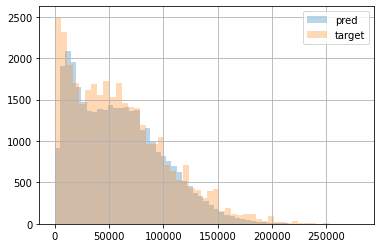

In [40]:
import matplotlib.pyplot as plt
pd.Series(oof_preds).hist(bins=50, alpha=0.3, label="pred").plot()
train_df["Salary"].hist(bins=50, alpha=0.3, label="target").plot()
plt.legend()
plt.show()

In [42]:
oof_df = pd.DataFrame({"pred": oof_preds, "target": train_df["Salary"]})

In [50]:
oof_df["error"] = oof_df["pred"] - oof_df["target"]
oof_df["abs_error"] = oof_df["error"].map(np.abs)
oof_df.reset_index(inplace=True)
oof_df = oof_df.rename(columns={"index": "No"})

[]

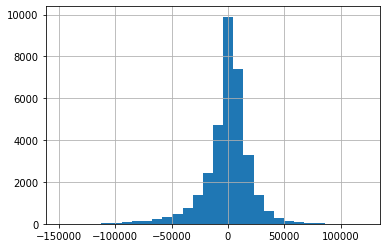

In [51]:
oof_df["error"].hist(bins=30).plot()

[]

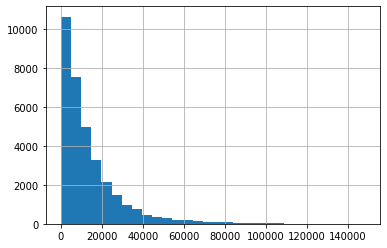

In [52]:
oof_df["abs_error"].hist(bins=30).plot()

[]

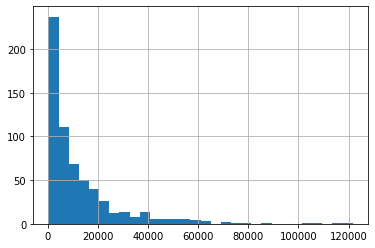

In [53]:
oof_df[oof_df["target"] == 0]["abs_error"].hist(bins=30).plot()

In [59]:
remove_no = oof_df[(oof_df["abs_error"] > 30000) & (oof_df["target"] == 0)]["No"].tolist()
len(remove_no)

67

In [33]:
importances.groupby("feature")["gain"].mean().sort_values(ascending=False).reset_index().iloc[:300]

,feature,gain
0,te_Country__SalaryType,4.573756e+08
1,te_Country__Employment,4.176125e+08
2,te_Country__Age,3.225687e+08
3,te_Country__YearsCodingProf,3.127602e+08
4,te_Country__YearsCoding,2.958806e+08
5,te_Country__ohe_DevType_Student,2.838776e+08
6,te_YearsCodingProf__CurrencySymbol,2.035802e+08
7,te_Country__ohe_Methodology_Agile,1.978364e+08
8,te_Country__FormalEducation,1.866648e+08
9,te_SalaryType__CurrencySymbol,1.685397e+08


In [62]:
len(use_cols)

2495

## Prediction

In [63]:
test_pred = np.zeros(len(test_df))

for model in models:
    test_pred += model.predict(test_df[use_cols]) / len(models)

In [64]:
test_pred

array([ 68709.4290526 ,  92121.54059259,  86709.05960104, ...,
        86293.35716303,  83213.56462796, 117570.0145847 ])

In [65]:
sub_df = pd.read_csv("../input/submit.csv")

In [66]:
sub_df["Salary"] = test_pred

In [67]:
sub_df.to_csv("../predict/028_remove_big_noise_20194.csv", index=False)